In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from datetime import date, timedelta
import seaborn as sns
from pandas.api.types import is_numeric_dtype
import yfinance as yf

sys.path.append( '/Users/bhundt/Documents/01 Basti/Interessen/Programmieren/FinDat/' )
from src.analysis.sentiment_analysis import get_sentiment

In [694]:
subreddit = 'wallstreetbets'
timeframe= '2010-2017'

filename = 'reddit_' + subreddit + '_submissions_' + timeframe + '.csv'

df = pd.read_csv('../data/'+filename, sep=';', decimal='.', encoding='utf-8')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date')
df = df.reset_index(drop=True)

# Filter posts without text

In [695]:
# filter deleted comments
df = df[df.Text.isin([np.nan, '', '[removed]', 'deleted']) == False]

# Posts per Day

In [696]:
posts_per_day = df.groupby(df.Date)['id'].agg('count').reset_index().rename(columns={'id':'num_submissions'})

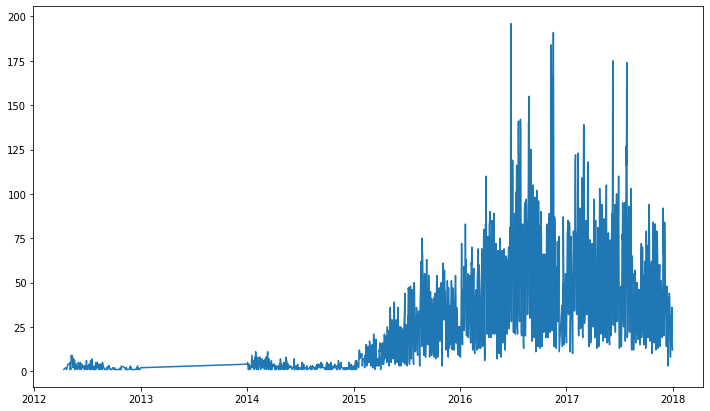

In [697]:
fig, ax = plt.subplots(figsize=(12, 7))
plt.plot(posts_per_day.Date, posts_per_day.num_submissions)
#plt.yscale('log')

# Comments per Day

In [698]:
comments_per_day = df.groupby(df.Date)['Comments'].agg('sum').reset_index()

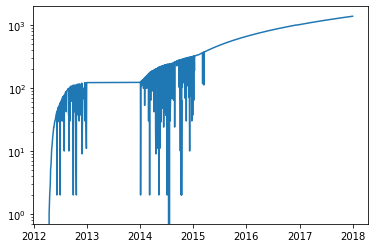

In [699]:
plt.plot(comments_per_day.Date, comments_per_day.Comments)
plt.yscale('log')

# Load S&P 500 Benchmark

In [700]:
sp500 = yf.Ticker('^GSPC')
hist = sp500.history(period='max', interval='1d')

hist = hist.reset_index()
hist['Date'] = pd.to_datetime(hist['Date'])

df = df.merge(hist[['Date', 'Close']], how='left', on='Date')
df = df.reset_index(drop=True)

# some missing values we need to fill
df['Close'] = df['Close'].interpolate(method='linear')
df['Close'] = df['Close'].fillna(method='backfill')

# Sentiment Analysis

## Calculate Sentiment - takes a while, this is why we export the file

In [701]:
df['sentiment_dict'] = df.apply( lambda row: get_sentiment(row['Title'] + '\n' + row['Text']), axis=1 )

df['pos'] = df.apply( lambda row: dict(row['sentiment_dict'])['pos'], axis=1 )
df['neu'] = df.apply( lambda row: dict(row['sentiment_dict'])['neu'], axis=1 )
df['neg'] = df.apply( lambda row: dict(row['sentiment_dict'])['neg'], axis=1 )
df['compound'] = df.apply( lambda row: dict(row['sentiment_dict'])['compound'], axis=1 )

sentiments = df.groupby(df.Date)[['pos', 'neg', 'neu', 'compound', 'Close']].agg('mean').reset_index()

## Store sentiments

In [702]:
sentiments.to_csv('../data/processed/sentiment_' + filename, sep=';', decimal='.', encoding='utf-8', index=False)

## Load sentiments

In [639]:
sentiments = pd.read_csv('../data/processed/sentiment_' + filename, sep=';', decimal='.', encoding='utf-8',)
sentiments['Date'] = pd.to_datetime(sentiments['Date'])

In [640]:
#sentiments = sentiments[ sentiments.Date <= pd.to_datetime("2020-03-01") ]

# fourier smoothing
cutoff = 50
N = len(sentiments['compound'])
y_hat = np.fft.rfft(sentiments['compound'], N)
y_hat[cutoff:] = 0
sentiments['compound_fft_smoothed'] = np.fft.irfft(y_hat, N)

## Plot Sentiment

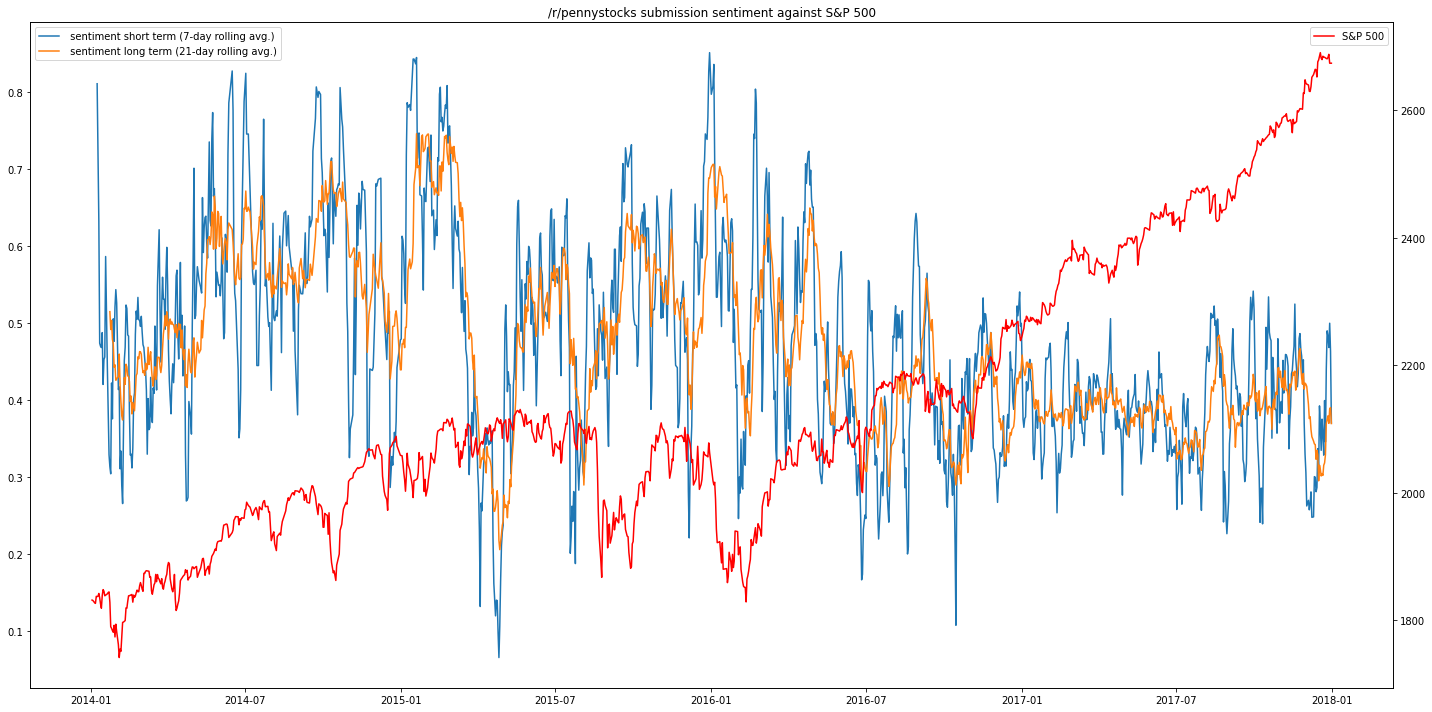

In [641]:
fig= plt.figure(figsize=(20, 10))
ax = plt.gca()
#ax.plot(sentiments.Date, sentiments.compound_fft_smoothed.rolling(10).mean(), label=' sentiment short term')
#ax.plot(sentiments.Date, sentiments.compound_fft_smoothed.rolling(20).mean(), label=' sentiment long term')

#ax.plot(sentiments.Date, sentiments.compound.ewm(alpha=0.02).mean(), label=' sentiment short term')
#ax.plot(sentiments.Date, sentiments.compound.ewm(alpha=0.01).mean(), label=' sentiment long term')

ax.plot(sentiments.Date, sentiments.compound.rolling(7).mean(), label=' sentiment short term (7-day rolling avg.)')
ax.plot(sentiments.Date, sentiments.compound.rolling(21).mean(), label=' sentiment long term (21-day rolling avg.)')

#ax.plot(sentiments.Date, sentiments.compound_fft_smoothed.ewm(alpha=0.1).mean())
#ax.plot(sentiments.Date, sentiments.compound_fft_smoothed.ewm(alpha=0.05).mean())

ax.legend(loc='upper left')

ax2=ax.twinx()
ax2.plot(sentiments.Date, sentiments.Close, 'r', label='S&P 500')
ax2.legend(loc=0)

plt.title('/r/' + subreddit + ' submission sentiment against S&P 500')
fig.tight_layout()
fig.savefig(filename + '.pdf', dpi=300, bbox_inches='tight')

# Average sentiments over different subreddits

In [28]:
files = [#'sentiment_reddit_stocks_submissions_2018-2021.csv',
        'sentiment_reddit_wallstreetbets_submissions_2018-2021.csv',
        #'sentiment_reddit_investing_submissions_2018-2021.csv',
        #'sentiment_reddit_stockmarket_submissions_2018-2021.csv',
        #'sentiment_reddit_pennystocks_submissions_2018-2021.csv',
        #'sentiment_reddit_stocks_submissions_2010-2017.csv',
        #'sentiment_reddit_wallstreetbets_submissions_2010-2017.csv',
        #'sentiment_reddit_investing_submissions_2010-2017.csv',
        #'sentiment_reddit_stockmarket_submissions_2010-2017.csv',
        #'sentiment_reddit_pennystocks_submissions_2010-2017.csv',
        ]

sentiments_all = []
for f in files:
    sentiments_all.append(pd.read_csv('../data/processed/' + f, sep=';', decimal='.', encoding='utf-8',))

sentiments_all = pd.concat(sentiments_all)
sentiments_all = sentiments_all.groupby(sentiments_all.Date).agg('mean').reset_index()
sentiments_all.Date = pd.to_datetime(sentiments_all.Date)

In [23]:
# fourier smoothing
N = len(sentiments_all['compound'])
y_hat = np.fft.rfft(sentiments_all['compound'], N)
y_hat[25:150] = 0
sentiments_all['compound'] = np.fft.irfft(y_hat, N)

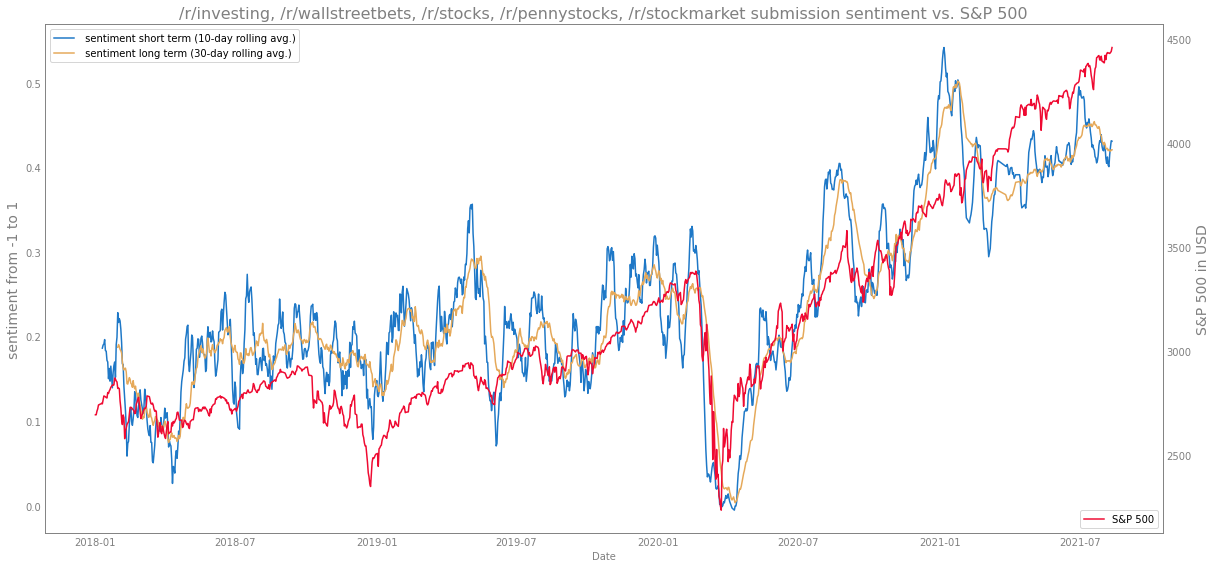

In [29]:
import seaborn as sns

fig= plt.figure(figsize=(17, 8))
ax = plt.gca()

ax.plot(sentiments_all.Date, sentiments_all.compound.rolling(10).mean(), label=' sentiment short term (10-day rolling avg.)', color=(30/256, 120/256, 200/256))
ax.plot(sentiments_all.Date, sentiments_all.compound.rolling(30).mean(), label=' sentiment long term (30-day rolling avg.)', color=(230/256, 170/256, 90/256))
ax.set_ylabel('sentiment from -1 to 1', color='gray', fontsize=14)
ax.set_xlabel('Date', color='gray')
ax.legend(loc='upper left')

ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray')
ax.spines['right'].set_color('gray')
ax.spines['top'].set_color('gray')
[t.set_color('gray') for t in ax.get_yticklabels()]
[t.set_color('gray') for t in ax.get_xticklabels()]
ax.xaxis.set_tick_params(length=0)
ax.yaxis.set_tick_params(length=0)

ax2=ax.twinx()
ax2.plot(sentiments_all.Date, sentiments_all.Close, color=(240/256, 10/256, 50/256), label='S&P 500')
ax2.set_ylabel('S&P 500 in USD', color='gray', fontsize=14)
ax2.legend(loc='lower right')

ax2.spines['bottom'].set_color('gray')
ax2.spines['left'].set_color('gray')
ax2.spines['right'].set_color('gray')
ax2.spines['top'].set_color('gray')
[t.set_color('gray') for t in ax2.get_yticklabels()]
[t.set_color('gray') for t in ax2.get_xticklabels()]
ax2.xaxis.set_tick_params(length=0)
ax2.yaxis.set_tick_params(length=0)

plt.title('/r/investing, /r/wallstreetbets, /r/stocks, /r/pennystocks, /r/stockmarket submission sentiment vs. S&P 500', color='gray', fontsize=16)
fig.tight_layout()
fig.savefig('all_sentiments.pdf', dpi=300, bbox_inches='tight')

# SLite 3 Test

In [2]:
import sqlite3

In [8]:
con = sqlite3.connect('../data/raw/test.sqlite3')

In [12]:
test_df = pd.DataFrame( {'Date': ['2021-08-14', '2021-08-14'], 'NumVal':[1, 2], 'StrVal':['a', 'b']} )

In [14]:
test_df.to_sql(name='TestTable', con=con, if_exists='append')

In [20]:
p2 = pd.read_sql('SELECT * FROM TestTable where Date = \'2021-08-11\'', con)

In [21]:
p2

,index,Date,NumVal,StrVal
0,1,2021-08-11,2,b
